# Swarms

In Underworld a swarm is a set of particles that can:

1. Advect inside the numerical domain.
2. Store user defined data (numpy array)

Hence swarms can track information in a lagrangian sense for Underworld models, eg material type in a slab subduction model.

#### Overview
1. Creating a swarm object and different layouts.
2. Creating a swarm from a numpy array and modifying positions.
3. Adding swarm particle variables.
4. Case-study, making a circle with particles.
5. Saving and loading swarms.


**Keywords:** swarms, particles, shapes


In [1]:
import underworld as uw
import glucifer
import numpy as np

## Creating a swarm object

In [2]:
# 1st a mesh is required to define a numerical domain
mesh = uw.mesh.FeMesh_Cartesian( elementRes  = (4, 4), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.))

# Initialise the swarm object with the mesh because the numerical domain is required
swarm = uw.swarm.Swarm( mesh=mesh )

#### Create a layout object

Layout objects are used to populate the swarm across the entire mesh domain.

The ``PerCellSpaceFillerLayout`` layout (default) fills each element with particles in a quasi-random pattern. It utilises Sobol sequences to generate cell (element) particle locations which are more uniformly distributed than a purely random generator.


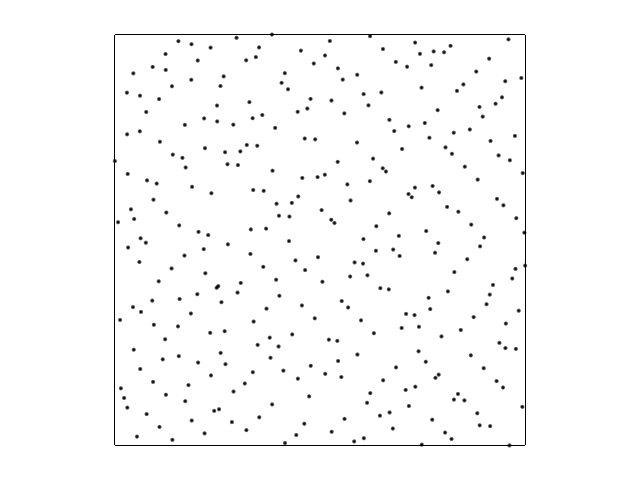

In [3]:
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )

# perform the populating
swarm.populate_using_layout( layout=swarmLayout )

# visualise the swarm
fig1 = glucifer.Figure()
fig1.Points(swarm=swarm, pointSize=5, colourBar=False)
fig1.show()

#### Other layout types

* ``PerCellRandomLayout``, uses a purely random distribution within each element, unlike the quasi-random ``GlobalSpaceFillerLayout``.  
`swarmLayout = uw.swarm.laddyouts.PerCellRandomLayout(swarm=swarm, particlesPerCell = 10)`


* ``GlobalSpaceFillerLayout``, uses a uniform quasi-random distribution of points applied to the entire domain. 
 This algorithm is not recommended because the algorthim does not scale well in parallel, nor does it behave well for deformed meshes.  
`swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell = 10)`


* ``PerCellGaussLayout``, puts a particle on each of the Gauss (quadrature) points within each mesh element.  
`swarmLayout = uw.swarm.layouts.PerCellGaussLayout( swarm=swarm, gaussPointCount=4 )`


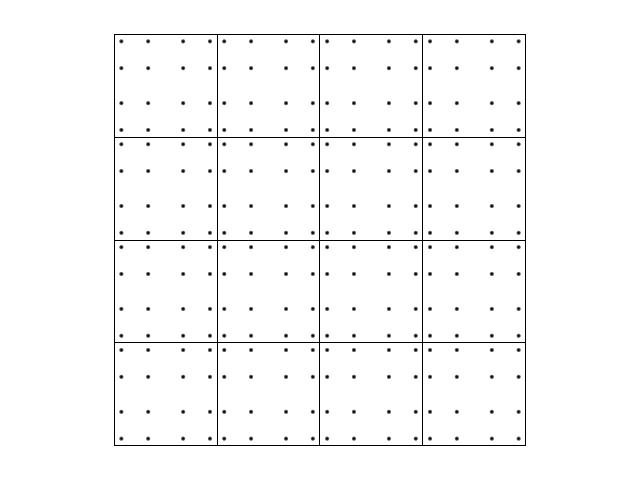

In [4]:
# example to a PerCellGaussLayout
swarm = uw.swarm.Swarm( mesh=mesh )
swarmLayout = uw.swarm.layouts.PerCellGaussLayout( swarm=swarm, gaussPointCount=4 )
swarm.populate_using_layout( layout=swarmLayout )

fig2 = glucifer.Figure()
fig2.Points(swarm=swarm, pointSize=5, colourBar=False)
fig2.Mesh(mesh)
fig2.show()

## Creating a swarm from numpy array

Swarms can also be populated via numpy arrays that define particle coordinates. 

In [5]:
# initialise a swarm
swarmCustom = uw.swarm.Swarm( mesh=mesh )

swarmCoords = np.array([ [0.2,0.2], [0.4,0.4],[0.6,0.6],[0.8,0.8],[1.8,1.8]])
# use this array to add particles to the newly created swarm
# note that the array returned from the following method specifies the 
# local identifier for the added particles.  particles which are not 
# inside the local domain (they may live on other processors), will 
# be signified with a -1

swarmCustom.add_particles_with_coordinates(swarmCoords)

array([ 0,  1,  2,  3, -1], dtype=int32)


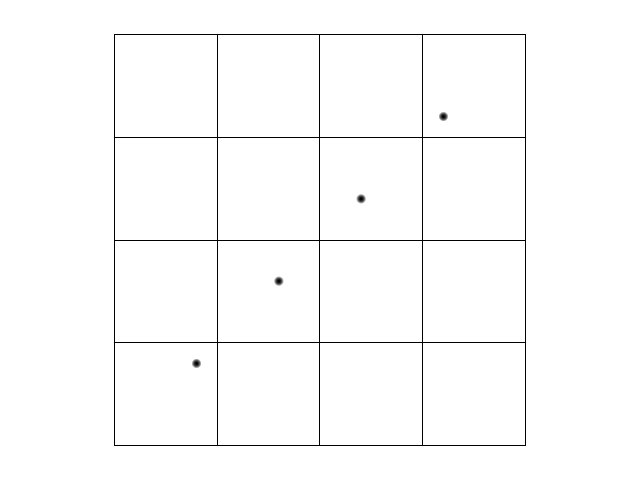

In [6]:
fig3 = glucifer.Figure()
fig3.Points(swarm=swarmCustom, pointSize=10, colourBar=False)
fig3.Mesh(mesh)
fig3.show()

### Modifying particle positions


**Shift a single particle**

Let's move a single particle. We will move the particle with local index 1, which as you can determin from the array returned from `add_particles_with_coordinates` is the particle with coordinates `(0.4,0.4)`.

Note that we need to use the `deform_swarm` context manager to modify particle locations. 


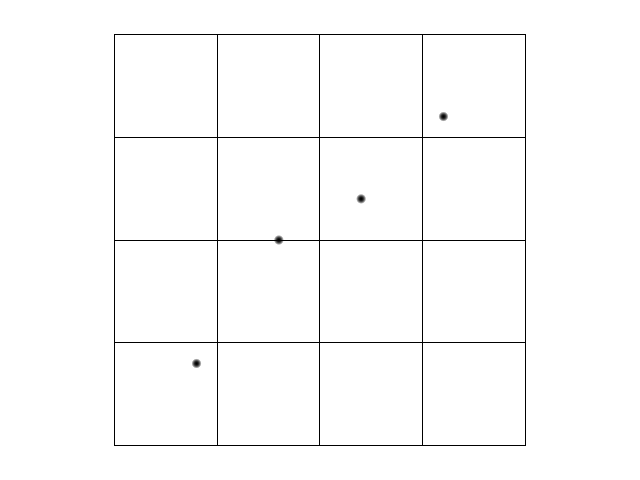

In [7]:
with swarmCustom.deform_swarm():
    swarmCustom.particleCoordinates.data[1] = (0.4,0.5)

# replot
fig3.show()

## Adding particle variables

Let us add a new variable to the swarm, that is each particle will save this information in a numpy array that we can access.

In [8]:
swarmVariable = swarmCustom.add_variable(dataType='double', count=1)

In [9]:
swarmVariable.data[0] = 1.
swarmVariable.data[1] = 10.
swarmVariable.data[2] = 100.
swarmVariable.data[3] = 1000.


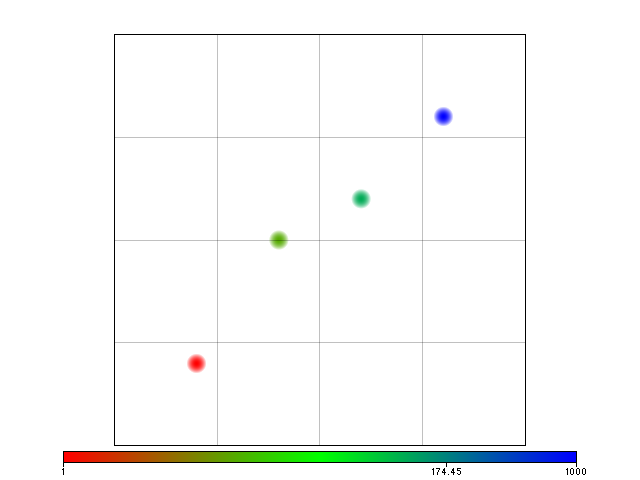

In [10]:
# plot the swarmVariable 

fig7 = glucifer.Figure()
fig7.Points( swarm=swarmCustom, pointSize=20, 
              fn_colour=swarmVariable, colourBar = True,
              colours="red green blue", logScale=True)
fig7.Mesh(mesh, opacity=0.25)
fig7.show()

## A case study - making a circle with particles


This example will demonstrate the creation of geometry using swarm variables. Particle geometries often form means to define initial fluid/material distribution in models. 

For more information on how this method can be used to set material parameters to particles see the **StokesSinker** example.

In [11]:
# Create a new high resolution mesh
mesh = uw.mesh.FeMesh_Cartesian( elementRes  = (64, 64), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.) )


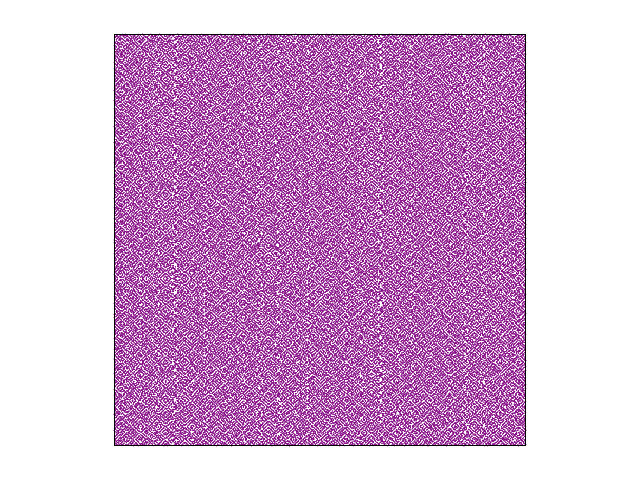

In [12]:
# initialise a swarm
swarm = uw.swarm.Swarm( mesh=mesh )
# add a data variable which will store an index to determine material
materialIndex = swarm.add_variable( dataType="int", count=1 )
# populate our swarm across the mesh domain
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )

# visualise the swarm... homogeneous
fig8 = glucifer.Figure()
fig8.Points( swarm=swarm, fn_colour=materialIndex, colours='blue red', 
                               colourBar = False, pointSize=2.0 )
fig8.show()

**Define a circle**

We want our `materialIndex` to define a circle. 

Here we use a python loop to traverse the particles and define the `materialIndex` depending on whether the particle's position is inside the circle or not.

More efficient ways to achieve this are presented in the **Functions** section of the user guide.

In [13]:
# our circles parameters
circleRadius = 0.1
circleCentre = (0.5, 0.5)

# the particle loop
for index, coord in enumerate(swarm.particleCoordinates.data):
    x = coord[0]
    z = coord[1]
    xx = x - circleCentre[0]
    zz = z - circleCentre[1]
    condition = (xx*xx + zz*zz < circleRadius**2)
    if(condition == True):  # inside the circle
        materialIndex.data[index] = 1
    else:
        materialIndex.data[index] = 0


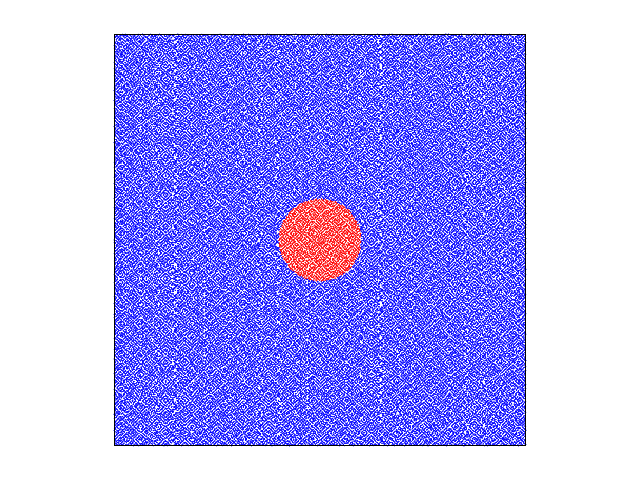

In [14]:
fig8.show()

## Saving and loading a swarm

In [15]:
## Save a swarm 

swarm.save("SwarmWithCircle.h5")
materialIndex.save("SwarmWithCircle.materialIndex.h5")


In [16]:
swarmCopy = uw.swarm.Swarm( mesh=mesh )
swarmCopy.load("SwarmWithCircle.h5")

# The swarm geometry is loaded but the swarmVariables are not restored.
# We have to explicitly create and re-populate any variables we have previously saved

materialIndexCopy = swarmCopy.add_variable("int",1)
materialIndexCopy.load("SwarmWithCircle.materialIndex.h5")



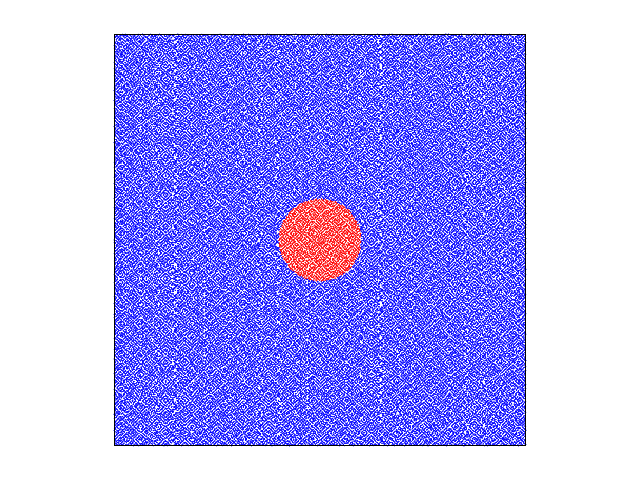

In [17]:
fig9 = glucifer.Figure()
fig9.Points( swarm=swarmCopy, fn_colour=materialIndexCopy, colours='blue red', 
              colourBar = False, pointSize=2.0 )
fig9.show()